# Predicting Wide Receiver Scores for Fantasy Football
### Overview
This project aims to predict the fantasy football scores of NFL wide receivers. It scrapes individual player receiving and team passing data from pro-football-reference.com, as well as average draft position (ADP) data from myfantasyleague.com for the 1998–2016 seasons. The data is cleaned and merged prior to feature engineering. The final dataset is used to make machine learning predictions with an ensemble of 5 algorithms.

### Key Questions Explored
- What is the model accuracy for predicting NFL wide receiver fantasy scores in the upcoming season?
- Which features correlate strongly with next season's fantasy points?
- Does the model improve upon conventional wisdom, i.e. the average draft position of players.

### Key Findings
- The final ensemble model following has an average root-mean-squared-error (RMSE) of ~2.8 fantasy points for out-of-sample data using 10-fold cross-validation. 


- For context of the RMSE, the top 10% of wide-receivers score ~15 fantasy points per game (FP/g), while the bottom 10% score ~8 FP/g, resulting in coefficient of variance around 15% and 33% respectively. Considering the small sample sizes for each season (16 games) and volatility of fantasy football performances, these predictions are relatively accurate.


- When comparing the projected rankings of the model (ordinal values) to the average draft position ranking from ~6000 drafts, the model has 30% higher accuracy in predicting the correct ranking for holdout data.

### Techniques used
- pandas and numpy for data scraping, exploration, and cleaning
- Pipeline and GridSearchCV for modeling and optimization
- Ridge / Lasso Regression, RandomForestRegressor, XGBoost, and KNearestNeighbors for modeling
- Principal Component Analysis (PCA) for dimensionality reduction
- seaborn and matplotlib for visualization

# Scrape Player, and Team Data

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from my_plot import PrettyPlot
PrettyPlot(plt);
plt.rcParams['savefig.dpi'] = 500;

### Function to Scrape and Load Data

In [2]:
def data_load(year_start, year_end, url, read_list):
    
    df = pd.DataFrame()
    years = reversed(range(year_start, year_end+1))
    
    for year in years:
        year = str(year)
        url_year = url.format(year)
        f = pd.read_html(url_year, header=0)
        f[read_list]['year'] = year
        df = df.append(f)
    df = df.reset_index(drop=True)
    return df

### Player Data
This cell uses the data_load function to scrape player receiving data from pro-football-reference.com for the 1998–2016 seasons.

In [3]:
year_start = 1998
year_end = 2016

url_player = 'https://www.pro-football-reference.com/years/{0}/receiving.htm'
data_player = data_load(year_start, year_end, url_player, 0)

### Team Data
This cell uses the data_load function to scrape team passing data from footballdb.com for the 2000–2016 seasons. This data will be merged with the receiving data to give context about the player's quarterback and team passing statistics.

In [4]:
url_team = 'http://www.footballdb.com/stats/teamstat.html?lg=NFL&yr={0}&type=reg&cat=P&group=O&conf='
data_team = data_load(year_start, year_end, url_team, 0)

### ADP data
The average draft position (ADP) of each player for the relevant seasons is pulled in below. The ADP is an average of where each player was selected in draft from myfantasyleague.com for each season (~6000 drafts). This data is incorporated into the model, and final model results are compared to these rankings.

In [5]:
url_adp = 'http://www03.myfantasyleague.com/{0}/adp?COUNT=100&POS=WR&ROOKIES=0&INJURED=0&CUTOFF=10\
&FRANCHISES=-1&IS_PPR=1&IS_KEEPER=0&IS_MOCK=-1&TIME='
data_adp = data_load(year_start, year_end+1, url_adp, 1)

In [6]:
url_adp_2017 = 'http://www03.myfantasyleague.com/2017/adp?COUNT=100&POS=WR&ROOKIES=0&INJURED=0&CUTOFF=10\
&FRANCHISES=-1&IS_PPR=1&IS_KEEPER=0&IS_MOCK=-1&TIME=1483246800'
data_adp_2017 = data_load(2017, 2017, url_adp_2017, 1)

# Cleaning the Datasets

### Cleaning Player Data
As shown below, the scraped data has oddities, such as an unnamed column for the player name, symbols on the player name, and rows that are out of order. The following cells will: (1) rename the player column, (2) rearrange the columns, and (3) clean up any non-numeric or standard string symobls.

In [7]:
data_player.shape
data_player.head()

(8522, 18)

,Rk,Unnamed: 1,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,Lng,R/G,Y/G,Fmb,year
0,1,Larry Fitzgerald*,ARI,33,WR,16,16,150,107,71.3%,1023,9.6,6,33,6.7,63.9,2,2016
1,2,Antonio Brown*+,PIT,28,WR,15,15,154,106,68.8%,1284,12.1,12,51,7.1,85.6,0,2016
2,3,Odell Beckham*,NYG,24,WR,16,16,169,101,59.8%,1367,13.5,10,75,6.3,85.4,3,2016
3,4,Julian Edelman,NWE,30,WR,16,13,159,98,61.6%,1106,11.3,3,77,6.1,69.1,3,2016
4,5,Jordy Nelson,GNB,31,WR,16,16,152,97,63.8%,1257,13.0,14,60,6.1,78.6,1,2016


In [8]:
def player_format(data):
    data = data.rename(columns={'Unnamed: 1': 'Player'})
    col_order = ['Player', 'Tm', 'Pos', 'year', 'Age', 'Ctch%', 'Fmb', 'G', 'GS', 'Lng',
             'R/G', 'Rec','TD', 'Tgt', 'Y/G', 'Y/R', 'Yds']
    df = data[col_order]
    df = df[pd.notnull(df['Player'])]
    return df

In [9]:
df_player = player_format(data_player)

There were two players named Steve Smith that caused downstream issues. Only one player was relevant for this study's purpose, so these cells select the relevant Steve Smith, while filtering out the other. 

In [10]:
steve_smith = df_player[(df_player.Player == 'Steve Smith') & ((df_player.Tm == 'NYG') | (df_player.Tm == 'STL') | (df_player.Tm == 'PHI'))]
df_player = df_player.drop(steve_smith.index).reset_index(drop=True)
df_player.shape

(8250, 17)

In [11]:
def name_clean(col):
    char_remove = re.sub('[\*\+\%\,]', '', str(col))
    return char_remove

Below, the cleaned player dataframe is shown.

In [12]:
df_player['Player'] = df_player.Player.apply(name_clean)
df_player['Ctch%'] = df_player['Ctch%'].apply(name_clean)
df_player.shape
df_player.head()

(8250, 17)

,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,R/G,Rec,TD,Tgt,Y/G,Y/R,Yds
0,Larry Fitzgerald,ARI,WR,2016,33,71.3,2,16,16,33,6.7,107,6,150,63.9,9.6,1023
1,Antonio Brown,PIT,WR,2016,28,68.8,0,15,15,51,7.1,106,12,154,85.6,12.1,1284
2,Odell Beckham,NYG,WR,2016,24,59.8,3,16,16,75,6.3,101,10,169,85.4,13.5,1367
3,Julian Edelman,NWE,WR,2016,30,61.6,3,16,13,77,6.1,98,3,159,69.1,11.3,1106
4,Jordy Nelson,GNB,WR,2016,31,63.8,1,16,16,60,6.1,97,14,152,78.6,13.0,1257


### Cleaning Team Data
As shown in the dataframe below, the team data also has an oddity in that it adds the city name after the nickname. The following cells will again rearrange the column order, followed by using regular expressions to split the strings and return only standard team names.

In [13]:
data_team.head()

,Team,Gms,Att,Cmp,Pct,Yds,TD,Int,Sack,Loss,Rate,NetYds,Yds/G,year
0,New Orleans SaintsNew Orleans,16,674,472,70.0,5258,38,15,27,184,102.5,5074,317.1,2016
1,Washington RedskinsWashington,16,607,407,67.1,4948,25,12,23,190,97.4,4758,297.4,2016
2,Atlanta FalconsAtlanta,16,537,374,69.6,4960,38,7,37,235,116.8,4725,295.3,2016
3,New England PatriotsNew England,16,550,368,66.9,4456,32,2,24,148,109.5,4308,269.2,2016
4,Indianapolis ColtsIndianapolis,16,584,370,63.4,4491,32,15,44,289,94.5,4202,262.6,2016


In [14]:
col_order_team = ['Team', 'year', 'Yds', 'Att', 'Cmp', 'Int', 'Loss', 'Pct', 'Rate', 'Sack', 'TD']
df_team = data_team[col_order_team]

The code below splits the team name at each capital letter and separates each word into its own string within a list. It then selects only unique strings (eliminating the duplicate city) and returns a joined string with the proper name, as shown below.

In [15]:
def unique_list(list_strings):
    ulist = []
    [ulist.append(x) for x in list_strings if x not in ulist]
    return ulist

team_names = []
for team in df_team.Team:
    name_separate = re.sub(r"(\w)([A-Z])", r"\1 \2", team)
    team_name = ' '.join(unique_list(name_separate.split()))
    team_names.append(team_name)
    
df_team['Team'] = team_names
df_team.head()

,Team,year,Yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD
0,New Orleans Saints,2016,5258,674,472,15,184,70.0,102.5,27,38
1,Washington Redskins,2016,4948,607,407,12,190,67.1,97.4,23,25
2,Atlanta Falcons,2016,4960,537,374,7,235,69.6,116.8,37,38
3,New England Patriots,2016,4456,550,368,2,148,66.9,109.5,24,32
4,Indianapolis Colts,2016,4491,584,370,15,289,63.4,94.5,44,32


In [16]:
df_team.dtypes

Team     object
year     object
Yds       int64
Att       int64
Cmp       int64
Int       int64
Loss      int64
Pct     float64
Rate    float64
Sack      int64
TD        int64
dtype: object

### Cleaning ADP data

The ADP has many columns that are not necessary, as well as an overall messy appearence. The relevent columns will be selected and cleaned below.

In [17]:
data_adp.head()

,#,# Drafts Selected In,Avg. Pick,Back To Top Of Page,Guest (Login),Max. Pick,Min. Pick,Player,Unnamed: 0,Unnamed: 1,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017 ADP Results,NaN,NaN
1,1.0,16.0,3.81,NaN,NaN,14.0,1.0,"Beckham, Odell NYG WR*",NaN,NaN,2017
2,2.0,16.0,4.38,NaN,NaN,9.0,1.0,"Brown, Antonio PIT WR",NaN,NaN,2017
3,3.0,16.0,4.88,NaN,NaN,26.0,1.0,"Evans, Mike TBB WR",NaN,NaN,2017
4,4.0,16.0,8.88,NaN,NaN,30.0,2.0,"Hopkins, DeAndre HOU WR",NaN,NaN,2017


In [18]:
df_adp = data_adp[['Player', 'year', 'Avg. Pick']].dropna()
df_adp_2017 = data_adp_2017[['Player', 'year', 'Avg. Pick']].dropna()

def name_select(col):
    first = col.split(' ')[1]
    last = col.split(' ')[0]
    new_col = ' '.join([first,last])
    return new_col

df_adp['Player'] = df_adp.Player.apply(name_select)
df_adp['Player'] = df_adp.Player.apply(name_clean)

df_adp_2017['Player'] = df_adp_2017.Player.apply(name_select)
df_adp_2017['Player'] = df_adp_2017.Player.apply(name_clean)

df_adp.update(df_adp_2017)

df_adp['year'] = df_adp.year.astype('float')
df_adp['year'] = df_adp['year'] - 1

The cleaned dataframe with draft information is shown below.

In [19]:
df_adp.head()

,Player,year,Avg. Pick
1,Antonio Brown,2016.0,3.88
2,Julio Jones,2016.0,5.76
3,Odell Beckham,2016.0,6.18
4,Mike Evans,2016.0,8.24
5,A.J. Green,2016.0,11.49


# Replace Full Team Name with Abbreviation
In order to merge the player and team dataframes together, the team listed for the player must match the team name in the team stats dataframe. Unfortunately, the team stats dataframe uses the full name, while the player dataframe uses the teams' abbreviations. This section will create a dictionary that matches the team abbreviation to the full team name, which will be mapped to each dataframe.

In [20]:
player_team_sort = pd.DataFrame(df_player.Tm.unique(), columns=['abb']).sort_values('abb')
player_team_sort = player_team_sort[2:].reset_index(drop=True)

team_sort = pd.DataFrame(df_team.Team.unique(), columns=['full']).sort_values('full').reset_index(drop=True)

team_names = pd.concat([player_team_sort, team_sort], axis=1)
team_names.head()

,abb,full
0,ARI,Arizona Cardinals
1,ATL,Atlanta Falcons
2,BAL,Baltimore Ravens
3,BUF,Buffalo Bills
4,CAR,Carolina Panthers


The dataframe above using alphabetical ordering of the team abbreviations and full team names matches the majority of teams correctly. However, a few are out of order and will need to be replaced manually, below.

In [21]:
team_names.loc[19, 'full'] = 'New Orleans Saints'
team_names.loc[20, 'full'] = 'New England Patriots'
team_names.loc[27, 'full'] = 'Seattle Seahawks'
team_names.loc[28, 'full'] = 'San Francisco 49ers'

Now that all teams are correctly matched, the dataframe can be made into a dictionary, with the full team name as the key and the abbreviation as a value. This dictionary will then be used with the map function to change all full team names in the team stats dataframe to team abbreviations that match the players.

In [22]:
team_dict = team_names.set_index('full', drop=True).to_dict()
df_team['Team'] = df_team.Team.map(team_dict['abb'])

As shown below, the team name was successfully changed to the abbreviated version. Now that the team names match the teams from the player dataframe, the two can be merged.

In [23]:
df_team.head()

,Team,year,Yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,TD
0,NOR,2016,5258,674,472,15,184,70.0,102.5,27,38
1,NaN,2016,4948,607,407,12,190,67.1,97.4,23,25
2,ATL,2016,4960,537,374,7,235,69.6,116.8,37,38
3,NWE,2016,4456,550,368,2,148,66.9,109.5,24,32
4,IND,2016,4491,584,370,15,289,63.4,94.5,44,32


# Merging Player and Team Data into Single Dataframe
Below, the team dataframe will be merged with the player dataframe according to the teams and the year, with a few duplicate columns renamed.

In [24]:
df_merged = pd.merge(df_player, df_team, how='left', left_on = ['Tm', 'year'], right_on = ['Team', 'year'])
df_merged.drop('Team', axis=1, inplace=True)
df_merged = df_merged.rename(columns={'Yds_x': 'rec_yds', 'Yds_y': 'pass_yds', 'TD_x': 'rec_td', 'TD_y': 'pass_td'})
df_merged.shape

(8250, 26)

### ADP merge

Now, the ADP data will be merged to the existing dataframe with the player and team statistics.

In [25]:
df_merged['year'] = df_merged['year'].astype('float')
df_merged = pd.merge(df_merged, df_adp, how='inner', left_on=['Player', 'year'], right_on=['Player', 'year'])
df_merged.shape
df_merged.head()

(1366, 27)

,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,...,pass_yds,Att,Cmp,Int,Loss,Pct,Rate,Sack,pass_td,Avg. Pick
0,Larry Fitzgerald,ARI,WR,2016.0,33,71.3,2,16,16,33,...,4425.0,646.0,383.0,17.0,289.0,59.3,83.5,41.0,28.0,64.53
1,Antonio Brown,PIT,WR,2016.0,28,68.8,0,15,15,51,...,4377.0,596.0,381.0,15.0,175.0,63.9,93.9,21.0,33.0,3.88
2,Odell Beckham,NYG,WR,2016.0,24,59.8,3,16,16,75,...,4027.0,598.0,377.0,16.0,148.0,63.0,86.0,22.0,26.0,6.18
3,Julian Edelman,NWE,WR,2016.0,30,61.6,3,16,13,77,...,4456.0,550.0,368.0,2.0,148.0,66.9,109.5,24.0,32.0,86.20
4,Jordy Nelson,GNB,WR,2016.0,31,63.8,1,16,16,60,...,4445.0,620.0,403.0,8.0,246.0,65.0,102.3,35.0,40.0,15.14


# Addressing Null Values
Now that the dataframes have merged, null values will be addressed. As shown below, the biggest category with null values is the position dataframe. Because these values were scraped from the receiving statistics of pro-football-focus, I will assume that the majority are wide-receivers who were not labeled properly. As a result, I will re-label them as wide-receivers and then filter out any other positions (e.g. runningback, tight end).

In [26]:
nulls = df_merged.isnull().sum()
nulls[nulls > 0]

Pos         64
pass_yds    53
Att         53
Cmp         53
Int         53
Loss        53
Pct         53
Rate        53
Sack        53
pass_td     53
dtype: int64

In [27]:
df_merged['Pos'] = df_merged.Pos.fillna('WR')
wr_replace = {
    'wr': 'WR',
    'WR': 'WR',
    'fb/WR': 'WR'
}

df_merged.Pos = df_merged.Pos.map(wr_replace)
df_merged = df_merged[pd.notnull(df_merged['Pos'])]
df_merged.isnull().sum()

Player        0
Tm            0
Pos           0
year          0
Age           0
Ctch%         0
Fmb           0
G             0
GS            0
Lng           0
R/G           0
Rec           0
rec_td        0
Tgt           0
Y/G           0
Y/R           0
rec_yds       0
pass_yds     53
Att          53
Cmp          53
Int          53
Loss         53
Pct          53
Rate         53
Sack         53
pass_td      53
Avg. Pick     0
dtype: int64

The remaining null values stem from players that were traded in-season and have two teams listed instead of one (not shown). As a result, the mapping above could not match a team's stats and returned a null value. Rather than individually looking up each of these players / teams and manually entering the stats, the null values will simply be replaced with median values, leaving no null values in the dataset.

In [28]:
df_merged = df_merged.fillna(df_merged.median()).dropna()
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

Series([], dtype: int64)

# Creating New Features and Adding Target Values
This section will create new features that will help to improve the model prediction accuracy. The first cell creates simple fantasy point (FP) columns for each wide receiver, as well as a quarterback fantasy point (QB FP) score that indicates how many points the wide receiver's quarterback threw for. Finally, a fantasy points per game (FP/G) feature is added, which will ultimately be our target value for predictions.

In [29]:
Yd_mult = 0.1
TD_val = 6.0
Rec_val = 1
Fmb = -2.0
point_values = [Yd_mult, TD_val, Rec_val, Fmb]

def fantasy_points(df, params):
    df.loc[:, 'year':] = df.loc[:,'year':].astype(float)
    df['FP'] = params[0]*df['rec_yds'] + params[1]*df['rec_td'] + params[2]*df['Rec'] + params[3]*df['Fmb']
    df['FP/G'] = df['FP'] / df['G']
    return df

df_merged = fantasy_points(df_merged, point_values)

df_merged['QB FP'] = .04*df_merged['pass_yds'] + 4*df_merged['pass_td'] - 2*df_merged['Int'] - 1*df_merged['Sack']

The function below completes three main tasks: 
- Creates historical metrics for the current season, such as career median or max fantasy points. In order to complete this task, the dataframe loops through each year and computes the historical metrics for each prior season. Thus, the historical metrics are based on information known during that season. For example, the prior 1998-2009 data would be known for the 2010 season. 


- Creates age-based features so that younger vs. older players are properly accounted for. Younger players may not put up as many points as more established players, but players that perform better early in their careers typically have more prolific numbers as they mature. Further, players tend to decline in performance as they age (typically after 30 years old).


- Adds the target values (Y_act) for the upcoming season. For example, the data where year = 2010 will have the FP/G from 2011 as the Y_act value. This metric was chosen because it is most relevant for the use case of predicting the upcoming season. The user would know the 2010 data and all previous season data, but would want to predict the upcoming 2011 season results. The 2016 data thus will not have any Y_act values because the 2017 season is not yet complete (as of this writing November 2017). The final machine learning algorithm will be used to predict the upcoming season values on the holdout data (2017).

In [30]:
def features_target(df, year_start, year_end, median_features, max_features, 
                    mean_features, age_features, target_feature):
    
    new_df = pd.DataFrame()
    years = range(year_start+1, year_end+1)

    for year in years:
        
        # adding the median features
        past = df[df['year'] <= year]
        for metric in median_features:
            past = past.join(past.groupby('Player')[metric].median(),on='Player', rsuffix='_median')
            
        for metric in max_features:
            past = past.join(past.groupby('Player')[metric].max(),on='Player', rsuffix='_max')
            
        for metric in mean_features:
            past = past.join(past.groupby('Player')[metric].mean(),on='Player', rsuffix='_mean')
            
        # adding the age features
        suffix = '/ age'
        for feature in age_features:
            feature_label = ' '.join([feature, suffix])
            past[feature_label] = past[feature] / past['Age']
        
        # adding the values for target feature
        year_n = past[past["year"] == year]
        year_n_plus_one = df[df['year'] == year+1][['Player', target_feature]].rename(columns={target_feature: 'Y_act'})
        year_n = pd.merge(year_n, year_n_plus_one, how='left', left_on='Player', right_on='Player')
        new_df = new_df.append(year_n)
    
    # creating dataframes to export
    new_df = new_df.sort_values(by=['year', 'FP'], ascending=[False, False])
    df_train_test = new_df[new_df.year < year_end].reset_index(drop=True)
    df_predict = new_df[new_df.year == year_end].drop('Y_act', axis=1).reset_index(drop=True)
    
    return df_train_test, df_predict

The list of features to be converted into median, max, mean, and age features are shown below. The output consists of a train / test dataframe that will be used for training and testing the model. The prediction dataframe will be the 2016 results that can be used to predict the upcoming 2017 season. The accuracy of these 2016 predictions will be compared to the most current information available (~75% completion of the season, as of November 2017).

In [32]:
median_features = ['FP', 'FP/G', 'QB FP', 'rec_td', 'Y/G', 'Tgt', 'Rec', 'Avg. Pick', 'pass_td']
max_features = ['FP', 'rec_td', 'Tgt', 'Y/G', 'Rec']
mean_features = []
age_features = ['FP', 'FP/G', 'Y/G', 'FP_median', 'FP_max']

df_train_test_raw, df_predict = features_target(df_merged, year_start, year_end, median_features, 
                                                max_features, mean_features, age_features, 'FP/G')

In [33]:
df_predict = df_predict.drop(df_predict.index[[38, 54]]).reset_index(drop=True)

In [34]:
df_predict.shape
df_train_test_raw.shape
df_train_test_raw.head()

(77, 49)

(1189, 50)

,Player,Tm,Pos,year,Age,Ctch%,Fmb,G,GS,Lng,...,rec_td_max,Tgt_max,Y/G_max,Rec_max,FP / age,FP/G / age,Y/G / age,FP_median / age,FP_max / age,Y_act
0,Antonio Brown,PIT,WR,2015.0,27.0,70.5,3.0,16.0,16.0,59.0,...,13.0,193.0,114.6,136.0,13.829630,0.864352,4.244444,9.216667,13.829630,20.426667
1,Julio Jones,ATL,WR,2015.0,26.0,67.0,3.0,16.0,16.0,70.0,...,10.0,203.0,116.9,136.0,14.042308,0.877644,4.496154,9.953846,14.042308,18.564286
2,Brandon Marshall,NYJ,WR,2015.0,31.0,63.0,3.0,16.0,16.0,69.0,...,14.0,192.0,94.3,118.0,10.877419,0.679839,3.029032,8.338710,10.877419,10.386667
3,DeAndre Hopkins,HOU,WR,2015.0,23.0,57.8,1.0,16.0,16.0,61.0,...,11.0,192.0,95.1,111.0,14.221739,0.888859,4.134783,9.956522,14.221739,12.337500
4,Odell Beckham,NYG,WR,2015.0,23.0,60.8,2.0,15.0,15.0,87.0,...,13.0,158.0,108.8,96.0,13.695652,0.913043,4.204348,13.184783,13.695652,18.231250


# Injury Replacement Values
One issue with the Y_act values is that many are null due to players not playing in the following season. Some reasons for the null values may include a season-ending injury during preseason or a retirement. These null values will simply be removed. Other methods such as imputing based on career median points, resulted in poorer performance accuracy on out-of-sample data.

In [35]:
print(df_train_test_raw.isnull().sum()[df_train_test_raw.isnull().sum() > 0])
df_train_test = df_train_test_raw.dropna()
df_train_test.shape

Y_act    327
dtype: int64


(862, 50)

# Exploring Features
With a clean dataset containing all relevant features, the correlations between each feature and the Y_act target value can be explored using seaborn's heatmap. Unsurprisingly, many of the engineered features are highly correlated with eachother and the features they were derived from. Somewhat surprisingly, the quarterback and team passing statistics do not strongly correlate with the receiver's statistics or the target Y_act value. 

While many of the features shown below have moderate correlation with the Y_act value (as high as 0.053 for the ADP data) it seems as though a lot of these features are redundant. The high multicolinearity with the dataset can lead to problems with certain machine learning algorithms.

For regression and k-nearest neighbors models below, I will use principal component analysis (PCA) for dimensionality reduction as part of a model pipeline. For decision tree methods, Random Forest and XGBoost, I will simply pass in all variables, as these techniques are better suited for handling multicollinearity.

When looking at the correlations, a few trends emerge in predicting the next year's fantasy points. It seems as though ADP, last season's yards and fantasy points, and career performance are important. Touchdowns correlate less strongly with next year's fantasy points because they are more random than a player accumulating yards. Somewhat surprisingly, the player's quarterback does not strongly correlate with next year's fantasy points.

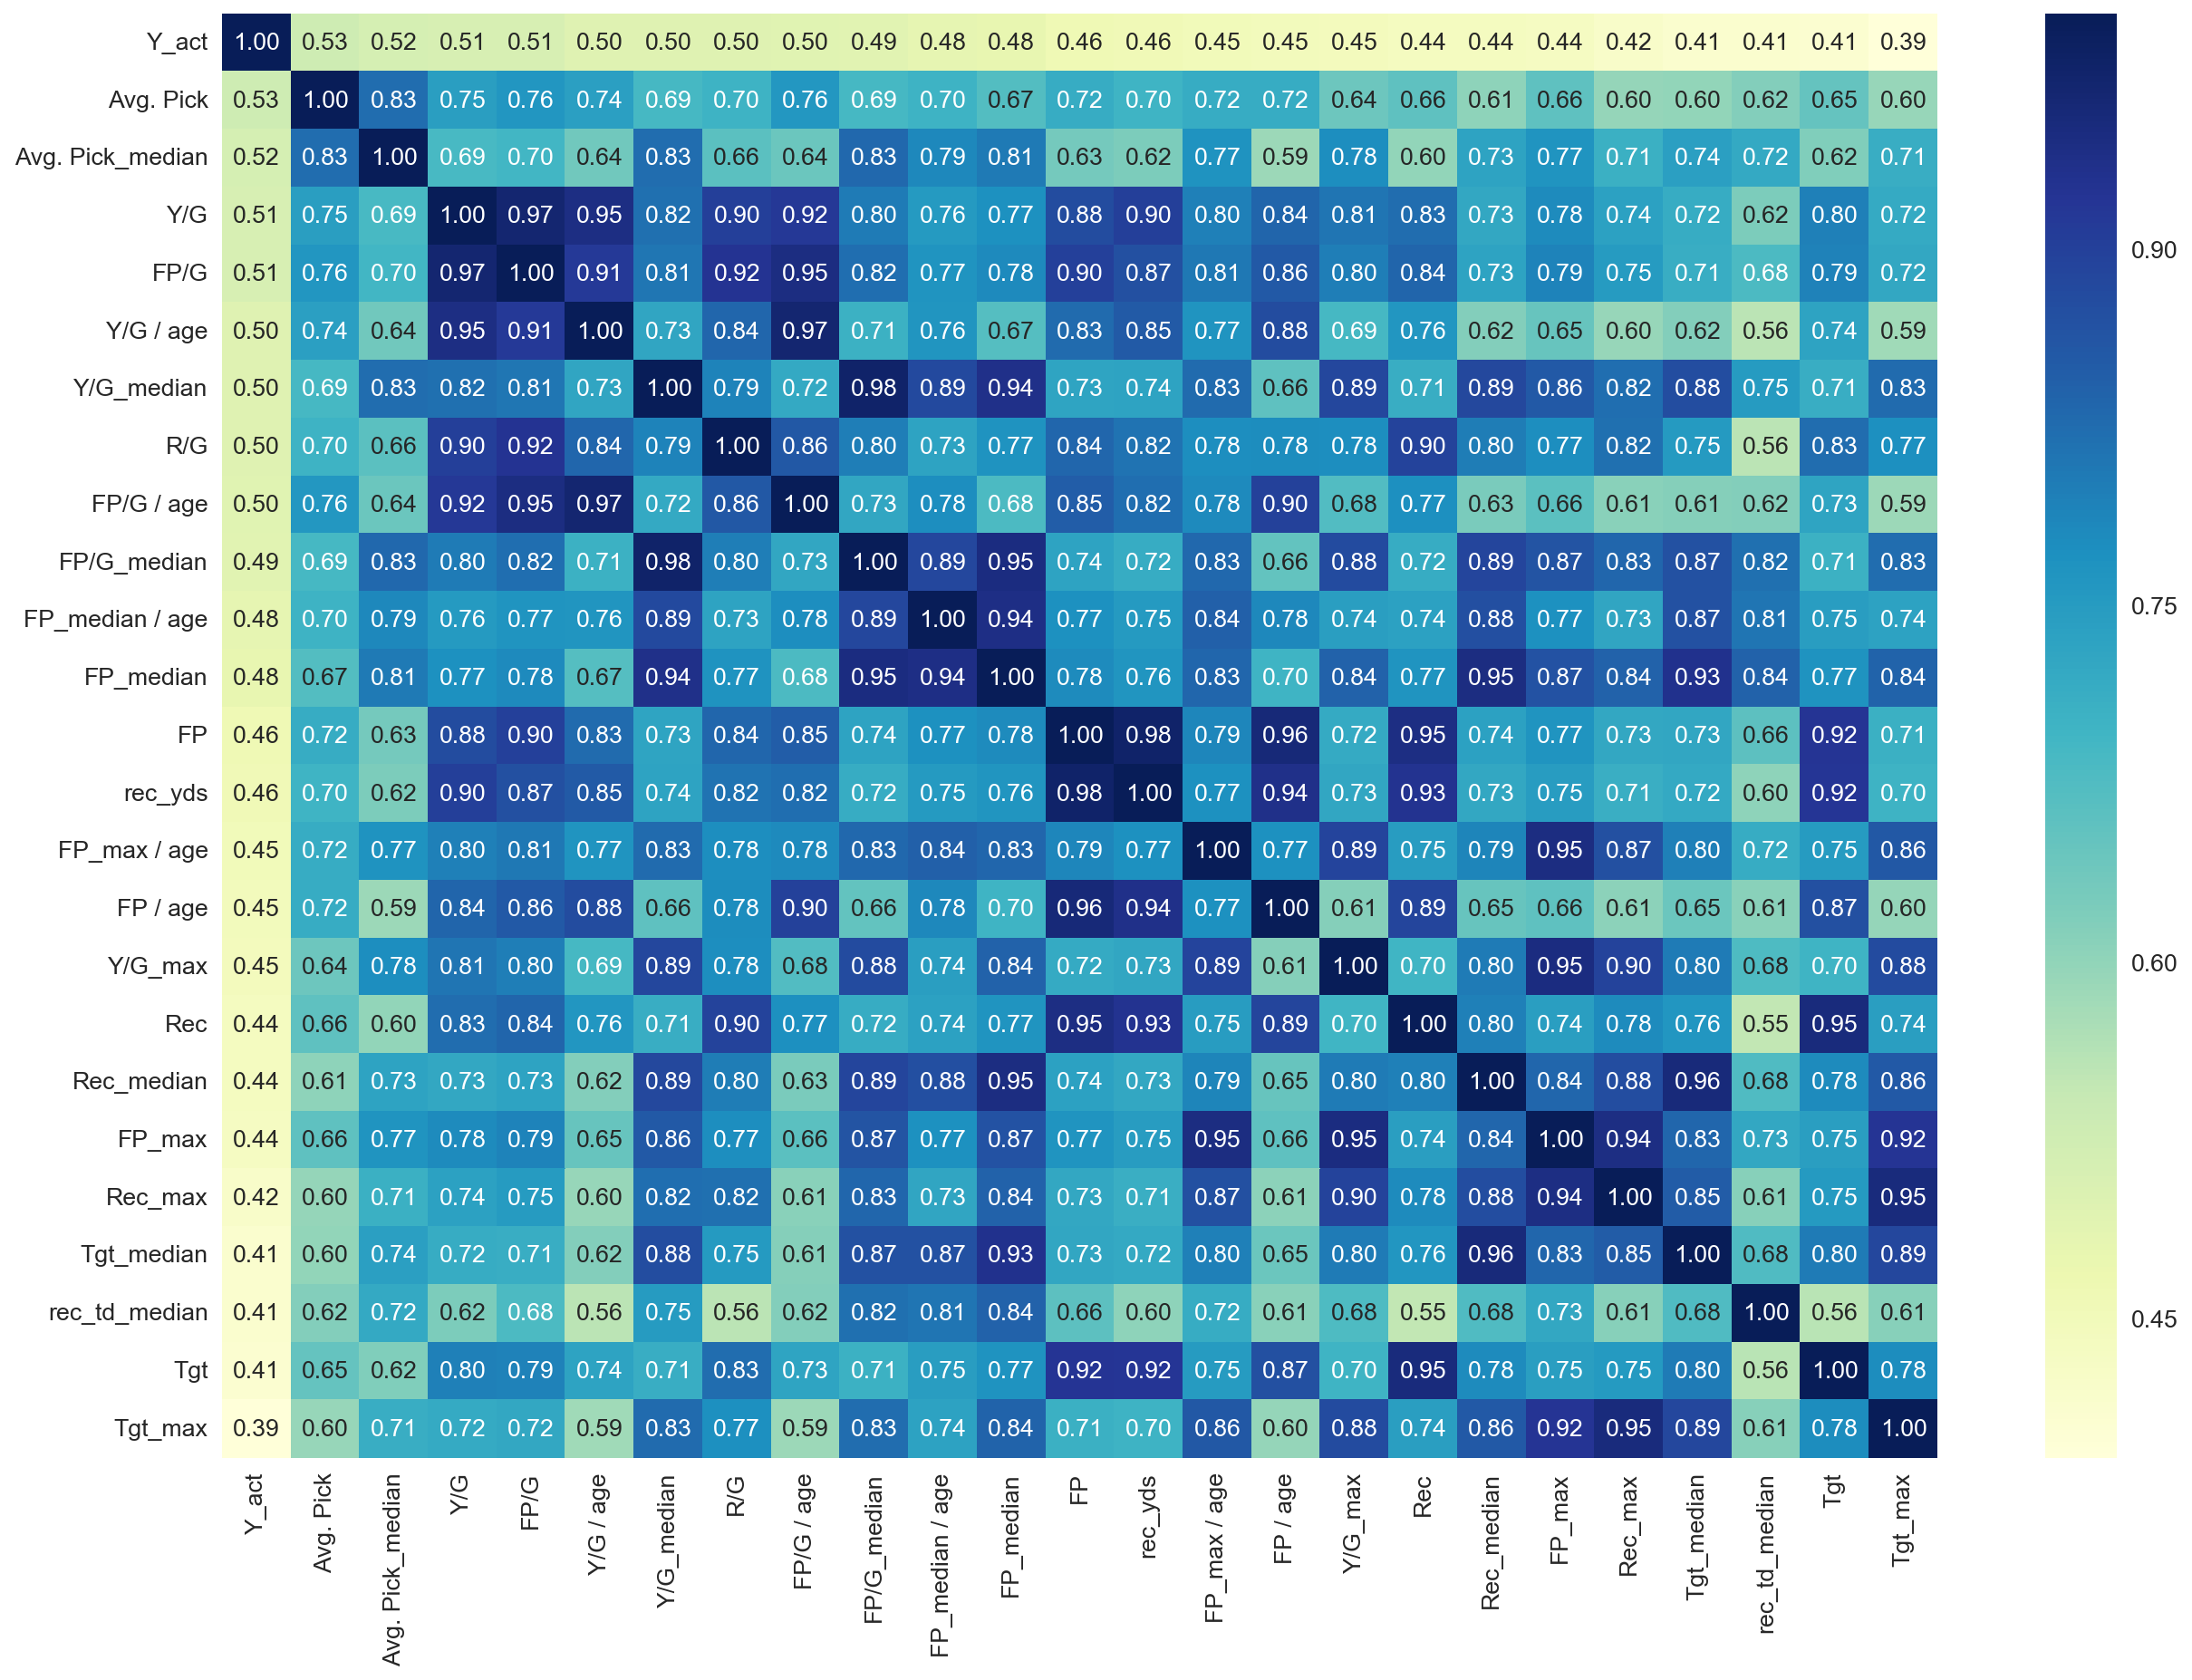

In [36]:
plt.figure(figsize=(17,12))
k = 25
corrmat = abs(df_train_test.corr())
cols_large = corrmat.nlargest(k, 'Y_act').index
hm_large = corrmat.nlargest(k,'Y_act')[cols_large]
sns.set(font_scale=1.2)
sns_plot = sns.heatmap(hm_large, cmap="YlGnBu", cbar=True, annot=True, square=False, fmt='.2f', 
                 annot_kws={'size': 12});

fig = sns_plot.get_figure();
PrettyPlot(plt);

Looking at the RMSE and R^2 values for the train and test datasets shows that the model has relatively high accuracy for predicting next season's fantasy football scores. Because the RMSE and R^2 values are similar between the train and test sets, it appears that the model has achieved relatively sufficient bias/variance tradeoff.

# Machine Learning Modeling

In [41]:
# data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# models to be trained
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# pipeline and optimization
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Creating cross-validation datasets, as well as the holdout dataset
The model will be trained on the remaining samples from 1998-2015. The 2016 data, which is used to predict the current 2017 season, will be witheld and analyzed separately. 

In [42]:
X = df_train_test.select_dtypes(include=['float']).drop('Y_act', axis=1)
y = df_train_test.Y_act
X_predict = df_predict.select_dtypes(include=['float'])

### Creating model pipelines with hyper-parameter optimization
The following three cells of code implement a straightforward approach for training and optimizing multiple models. The select_model function below accepts a model and training data to perform a grid search for hyperparameter optimization with cross-validation. The best scores, parameters, and model are returned.

In [43]:
def select_model(X, y, models):
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring='neg_mean_squared_error',
                            cv=10)
        grid.fit(X, y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

Below, pipelines for three of the models are created. In each of these models, the data is scaled prior to transformation with PCA. PCA is used for these three models to prevent collinearity for the regression models, and to reduce training time for the KNN algorithm. The decision tree models will use un-processed models.

In [44]:
lr_pipe = [
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1)),
    ('ridge', Ridge())
]

RidgePipe = Pipeline(lr_pipe)

lr_lasso = [
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1)),
    ('lasso', Lasso())
]

LassoPipe = Pipeline(lr_lasso)

knn_pipe = [
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1)),
    ('knn', KNeighborsRegressor())
]

KNNPipe = Pipeline(knn_pipe)

Below, the 5 models to be trained are shown, along with the parameters to be optimized. The select_model function will accept each model along with the dictionary of hyperparameters for optimization. It will train a model each using parameter iteration and return the optimized model, parameters, and results. The Pipeline model is used for the three models with transformations prior to modeling.

In [45]:
models = [
        {
            "name": "RidgePipe",
            "estimator": RidgePipe,
            "hyperparameters":
            {
                'pca__n_components': [5, 7, 10, 12, 15, 18, 20, 25, 30, 40],
                'ridge__alpha': [5, 10, 25, 50, 75, 100, 125, 150, 200]
            }
        },
        {
            "name": "LassoPipe",
            "estimator": LassoPipe,
            "hyperparameters":
            {
                'pca__n_components': [5, 7, 10, 12, 15, 18, 20, 25, 30, 40],
                'lasso__alpha': [0.001, 0.01,.05, 0.1, .025, 0.5, 1, 5, 10]
            }
        },
        {
            "name": "KNNPipe",
            "estimator": KNNPipe,
            "hyperparameters":
                {
                    'pca__n_components': [20],
                    "knn__n_neighbors": range(1,125, 15),
                    "knn__weights": ["distance", "uniform"],
                    "knn__algorithm": ["ball_tree", "kd_tree", "brute"],
                    "knn__p": [1,2]
                }
        },
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [3, 6, 9],
                    "max_depth": [2, 3, 4],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [5, 8, 10],
                    "min_samples_split": [0.05, 0.1, 0.15]
                }
        },
        {
            "name": "XGBoost",
            'estimator': XGBRegressor(),
            'hyperparameters':
            {
                'n_estimators': [40, 50],
                'learning_rate': [0.1, 0.15],
                'max_depth': [1, 2],
                'min_child_weight': [5, 10],
                'subsample': [0.5, 0.75, 1],
                'reg_lambda': [2.5, 5]
            }
        }
    ]

The results for each model is shown below, including the best cross-validated score and parameters. The cross-validated score is the negative mean-squared error, which when converted to RMSE, gives errors of roughly 3.5 for out-of-sample data. All models appear to have similar out-of-sample error rates, and will be used for ensemble modeling. 

In [46]:
result = select_model(X, y, models)

RidgePipe
---------
Best Score: -12.208862624796982
Best Parameters: {'pca__n_components': 20, 'ridge__alpha': 150}

LassoPipe
---------
Best Score: -12.166760837073854
Best Parameters: {'lasso__alpha': 0.05, 'pca__n_components': 18}

KNNPipe
-------
Best Score: -12.514991546133864
Best Parameters: {'knn__algorithm': 'brute', 'knn__n_neighbors': 61, 'knn__p': 2, 'knn__weights': 'uniform', 'pca__n_components': 20}

RandomForestRegressor
---------------------
Best Score: -12.211222849446008
Best Parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.1, 'n_estimators': 6}

XGBoost
-------
Best Score: -12.081593886416654
Best Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 50, 'reg_lambda': 2.5, 'subsample': 0.75}



The best model for each of the ridge, lasso, knearest neighbors, random forest, and xgboost models will be used to make predictions on the holdout data for the current season.

In [47]:
holdout = X_predict

ridge_predict = pd.Series(result[0]['best_model'].predict(holdout), name='ridge')
lasso_predict = pd.Series(result[1]['best_model'].predict(holdout), name='lasso')
knn_predict = pd.Series(result[2]['best_model'].predict(holdout), name='knn')
rf_predict = pd.Series(result[3]['best_model'].predict(holdout), name='rf')
xgb_predict = pd.Series(result[4]['best_model'].predict(holdout), name='xgb')

# Importing actual 2017 values
Because ~75% of the season has passed at the time of writing, the model predictions to-date can be compared to actual results. Below, the current 2017 season data is pulled in and cleaned. The FP/G target metric is also calculated for comparison purposes.

In [48]:
url_player_2017 = 'https://www.pro-football-reference.com/years/2017/receiving.htm'
data_player_2017 = data_load(2017, 2017, url_player_2017, 0)

In [49]:
df_player_2017 = player_format(data_player_2017)
df_player_2017['Player'] = df_player_2017.Player.apply(name_clean)
df_player_2017['Ctch%'] = df_player_2017['Ctch%'].apply(name_clean)
df_player_2017 = df_player_2017[df_player_2017.Pos == 'WR']
df_player_2017 = df_player_2017.rename(columns={'Yds':'rec_yds', 'TD':'rec_td'})

In [50]:
Yd_mult = 0.1
TD_val = 6.0
Rec_val = 1.0
Fmb = -2.0
point_values = [Yd_mult, TD_val, Rec_val, Fmb]

df_player_2017 = fantasy_points(df_player_2017, point_values)

# Creating ensemble predictions and comparing to true predictions
Below, the predictions made by each model for the holdout data is averaged to give a final prediction value. It is then combined into a single dataframe with the actual values, and the plot below shows the comparison. The predicted values are red, while the actual values for the season are blue.

In [51]:
# create ensemble of models
include_models = [ridge_predict, lasso_predict, xgb_predict, knn_predict, rf_predict]
ensemble = pd.Series(np.mean(include_models, axis=0), name='fpg')

# series with predicted and true values
yhat = pd.concat([df_predict.Player, ensemble], axis=1)
ytrue = df_player_2017[['Player', 'FP/G']]

In [52]:
# merging prediction and true values
compare = pd.merge(yhat, ytrue, how='inner', right_on='Player', left_on='Player')
compare = compare.rename(columns={'fpg':'prediction', 'FP/G':'actual'})
compare = compare.sort_values('prediction', ascending=False).reset_index(drop=True)

# adding rankings to player names
for i, name in enumerate(compare.Player):
    compare['Player'][i] = ''.join([str(i+1), '.', ' ', name])

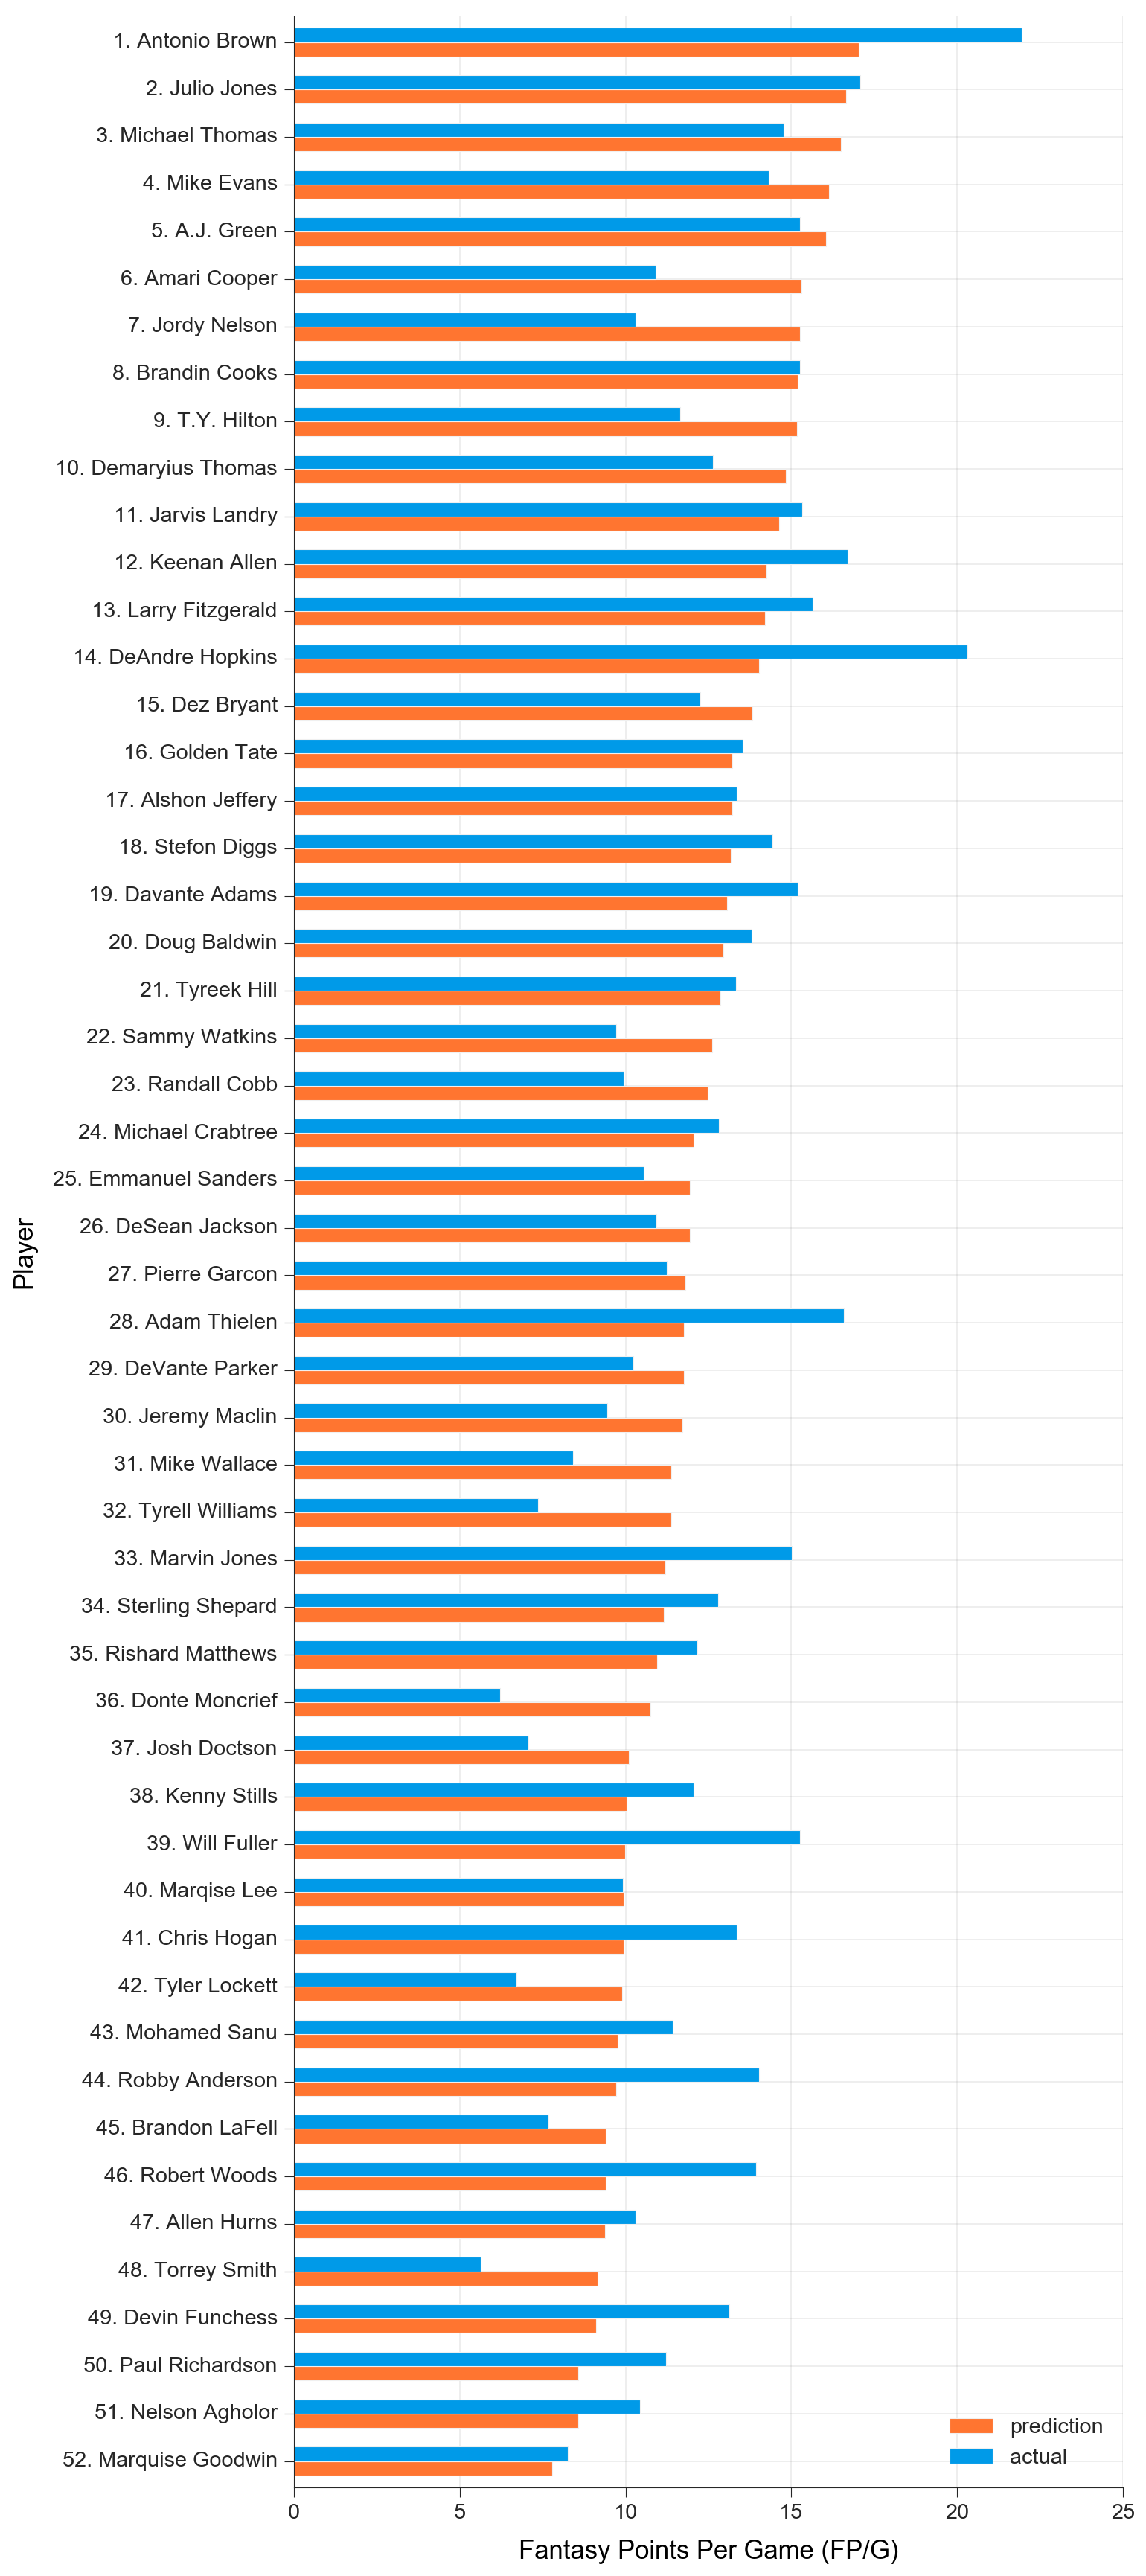

In [53]:
# plotting the model predictions and actual to-date values for each player
compare_plot = compare.set_index('Player').sort_values('prediction')
ax = compare_plot.plot.barh(figsize=(8, 25), color=['#ff7530', '#009ae8'], width=0.6);
ax.set_xlabel('Fantasy Points Per Game (FP/G)');

Finally, the error metrics can be calculated. Overall, the model performs relatively well, with an RMSE of 2.81 for the holdout data, and an MAE of 2.33. As shown above, the top players score 15–17.5 points per game, while the bottom players score around 10 points per game, for error rates of ~15% and 25% respectively.

In [54]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('Holdout FP/G RMSE:', round(mean_squared_error(compare.prediction, compare.actual)**0.5, 2))
print('Holdout FP/G MAE: ', round(mean_absolute_error(compare.prediction, compare.actual), 2))

Holdout FP/G RMSE: 2.81
Holdout FP/G MAE:  2.33


# ADP rank compare

While the projections above and error rates are interesting, it's important to determine whether this model improves upon conventional wisdom. Below, the projected model rankings for each player is compared to the average draft position (ADP) from about 6000 drafts (i.e. conventional wisdom). The difference between the players current, actual ranking and the model projection / ADP is computed and compared.

### Make rankings
The player rankings for actual, model projections, and ADP are created.

In [55]:
def make_rank(df, col, label, direction):
    df = df.sort_values(col, ascending=direction).reset_index(drop=True)
    col_name = '_'.join([label,'rank'])
    df[col_name] = df.index + 1
    return df

In [56]:
# rankings for model, ADP, and true respectively
yhat_rank = make_rank(yhat, 'fpg', 'Model', False)
df_adp_2017_rank = make_rank(df_adp_2017, 'Avg. Pick', 'MFL_ADP', True)
ytrue_rank = make_rank(ytrue, 'FP/G', 'Actual', False)

In [57]:
# merging all rankings into single dataframe
rank_compare = pd.merge(yhat_rank, df_adp_2017_rank, how='inner', left_on='Player', right_on='Player')
rank_compare = pd.merge(rank_compare, ytrue_rank, how='inner', left_on='Player', right_on='Player')
rank_compare = rank_compare[['Player', 'Model_rank', 'MFL_ADP_rank', 'Actual_rank']]

In [58]:
rank_compare['MFL - Actual'] = rank_compare.MFL_ADP_rank - rank_compare.Actual_rank
rank_compare['Model - Actual'] =  rank_compare.Model_rank - rank_compare.Actual_rank
rank_compare = rank_compare.sort_values('Actual_rank').reset_index(drop=True)
for i, name in enumerate(rank_compare.Player):
    rank_compare['Player'][i] = ''.join([str(i+1), '.', ' ', name])

### Visualization of the MFL ADP and Model Projection difference with Actual Rankings
The differences for the ADP rankings from myfantasyleague (MFL) and the model compared to the actual rankings are shown below. In this case, a difference of zero means the prediction or ADP was perfectly correct to the actual outcome. In other words, large error bars in the plot below mean a worse prediction or ADP. Overall, the model shows closer predictions compared to the actual outcome than conventional wisdom conveyed through MFL ADP.

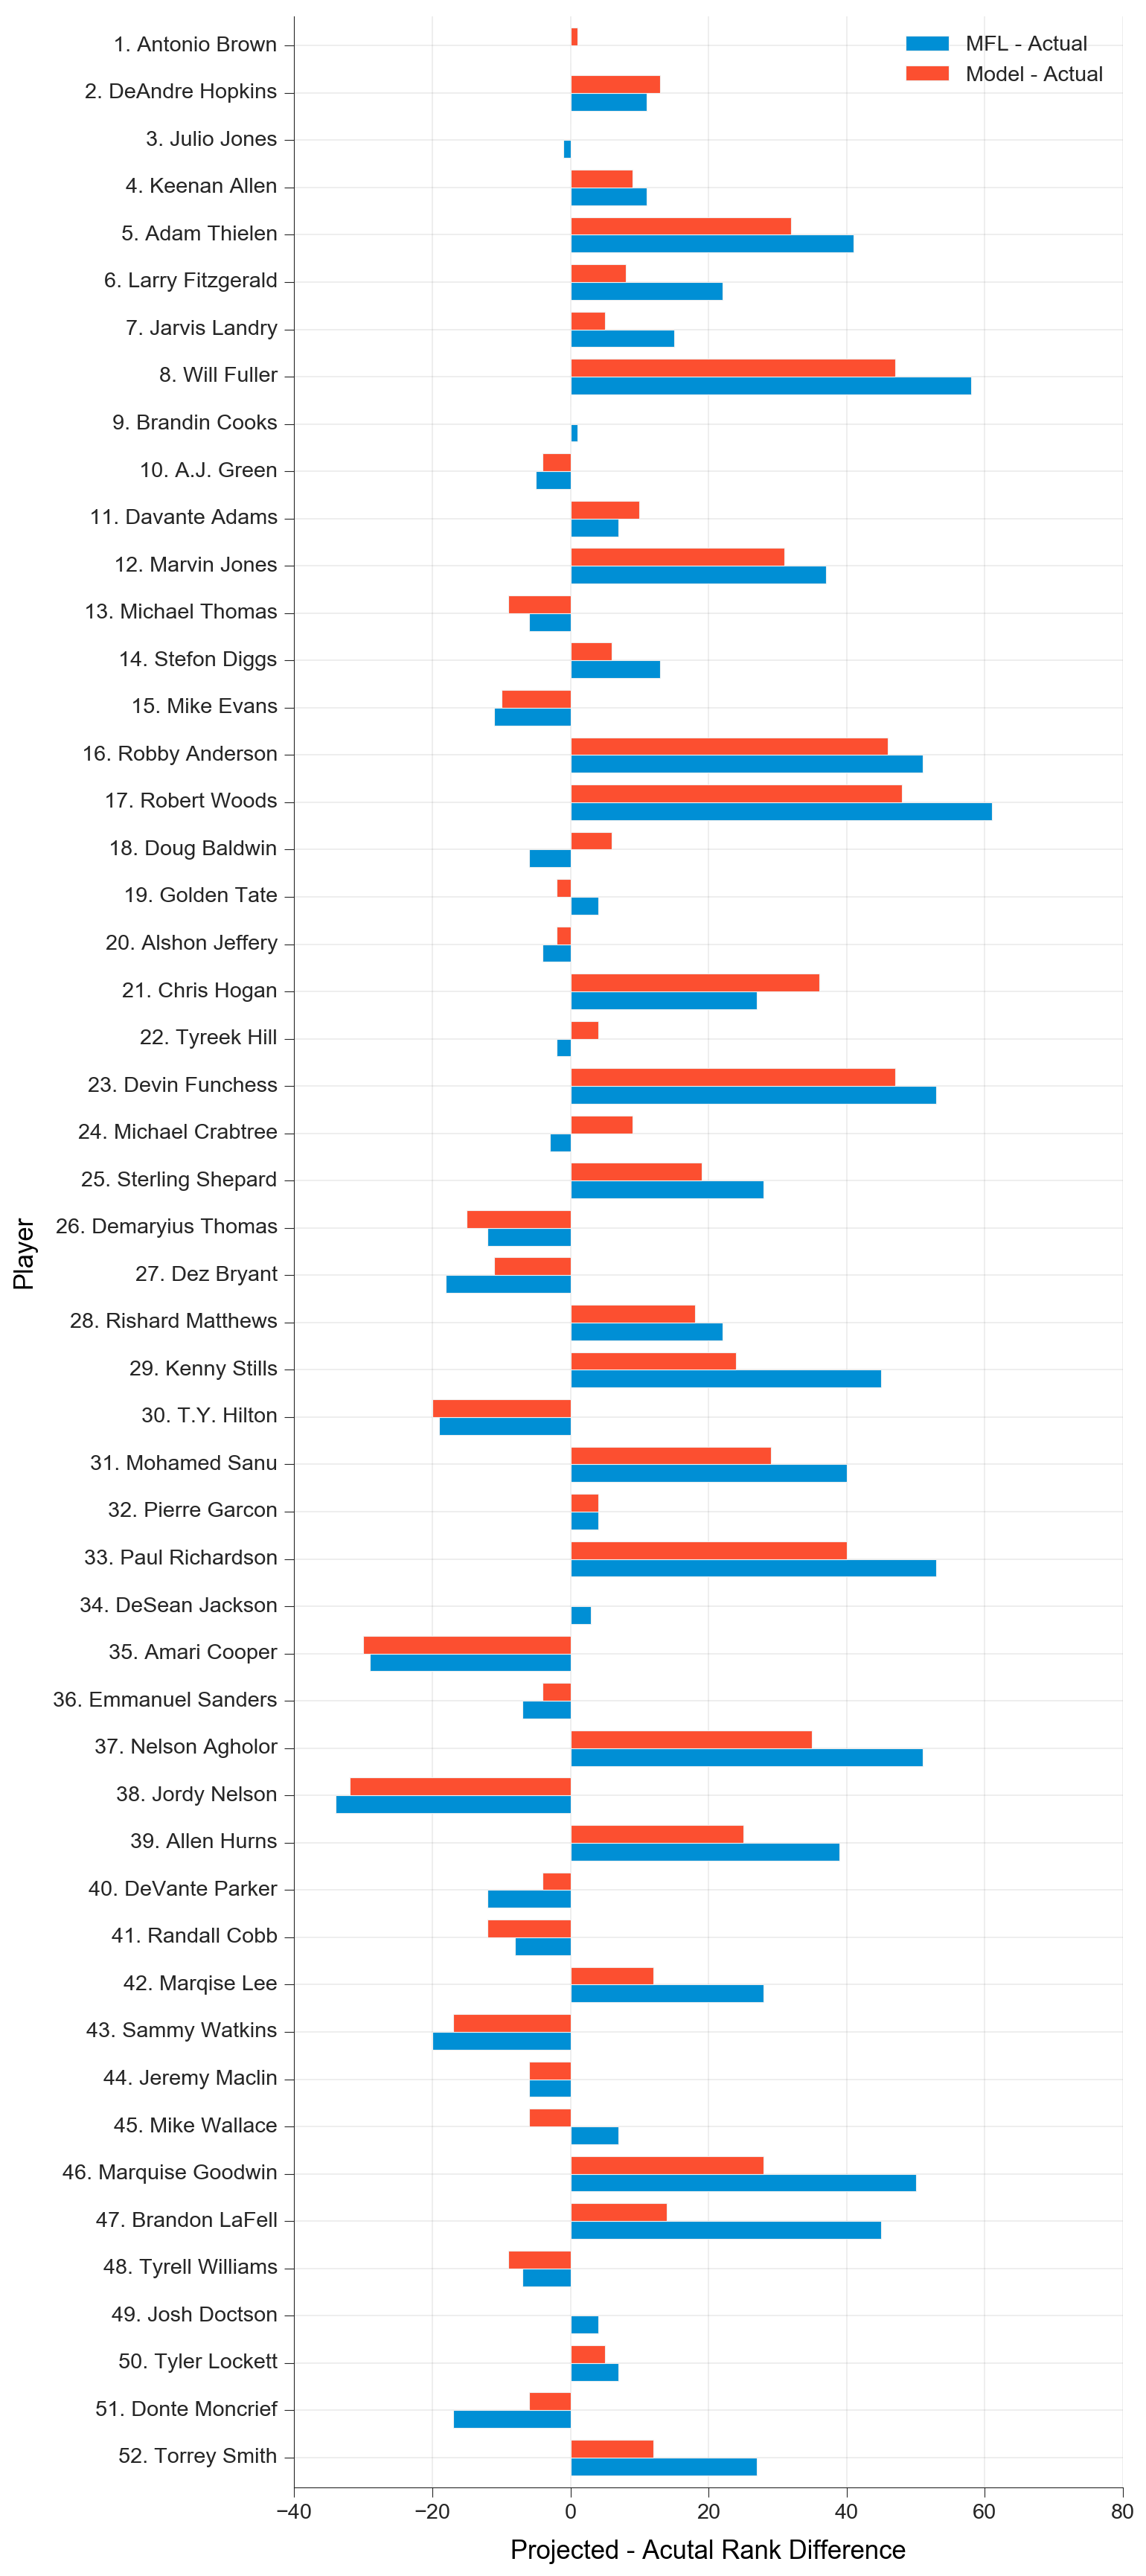

In [59]:
cols = ['Player', 'MFL - Actual', 'Model - Actual', 'Actual_rank']
rank_compare_plot = rank_compare[cols].set_index('Player').sort_values('Actual_rank', ascending=False)
ax = rank_compare_plot.drop('Actual_rank',axis=1).plot.barh(figsize=(8,25), width=0.75);
ax.set_xlabel('Projected - Acutal Rank Difference');

Finally, the mean differences for MFL ADP and the model are shown below. It confirms the graphical representation above that the model does indeed provide more accurate rankings, by ~33% on average. This result makes sense because the MFL ADP is incorporated into the model, and then enhanced with additional statistical features to create the final prediction.

In [60]:
print('Mean Difference Error, MFL ADP:', round(np.abs(np.mean(rank_compare['MFL - Actual'])), 2))
print('Mean Difference Error, Model:  ', round(np.abs(np.mean(rank_compare['Model - Actual'])), 2))

Mean Difference Error, MFL ADP: 12.27
Mean Difference Error, Model:   8.15
